In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
import random


2025-05-10 07:29:42.503918: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746862182.719303      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746862182.781675      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
class DataGenerator(Sequence):
    def __init__(self, image_filenames, mask_filenames, image_folder, mask_folder, batch_size=1, img_size=(256, 256)):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.batch_size = batch_size
        self.img_size = img_size
        self.indexes = np.arange(len(self.image_filenames))

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.image_filenames[k] for k in indexes]
        batch_masks = [self.mask_filenames[k] for k in indexes]
        images, masks = self.__load_batch(batch_images, batch_masks)
        return images, masks

    def __load_batch(self, batch_images, batch_masks):
        images = []
        masks = []
        for img_file, mask_file in zip(batch_images, batch_masks):
            img = load_img(os.path.join(self.image_folder, img_file), target_size=self.img_size)
            img = img_to_array(img) / 255.0
            mask = load_img(os.path.join(self.mask_folder, mask_file), target_size=self.img_size, color_mode='grayscale')
            mask = img_to_array(mask) / 255.0
            images.append(img)
            masks.append(mask)
        return np.array(images), np.array(masks)

In [ ]:
dataset_path = "/kaggle/input/flood-dataset/flood detection dataset"
image_folder =  f"{dataset_path}/Image"
mask_folder = f"{dataset_path}/Mask"
if os.path.exists(image_folder) and os.path.exists(mask_folder):
    image_filenames = sorted(os.listdir(image_folder))
    mask_filenames = sorted(os.listdir(mask_folder))

In [ ]:
from sklearn.model_selection import train_test_split

train_images, temp_images, train_masks, temp_masks = train_test_split(
    image_filenames, mask_filenames, test_size=0.2, random_state=42
)

val_images, test_images, val_masks, test_masks = train_test_split(
    temp_images, temp_masks, test_size=0.33, random_state=42 
)

train_generator = DataGenerator(train_images, train_masks, image_folder, mask_folder, batch_size=1)
val_generator = DataGenerator(val_images, val_masks, image_folder, mask_folder, batch_size=1)
test_generator = DataGenerator(test_images, test_masks, image_folder, mask_folder, batch_size=1)

print(f"Training set: {len(train_images)} images")
print(f"Validation set: {len(val_images)} images")
print(f"Test set: {len(test_images)} images")

Training set: 231 images
Validation set: 38 images
Test set: 20 images


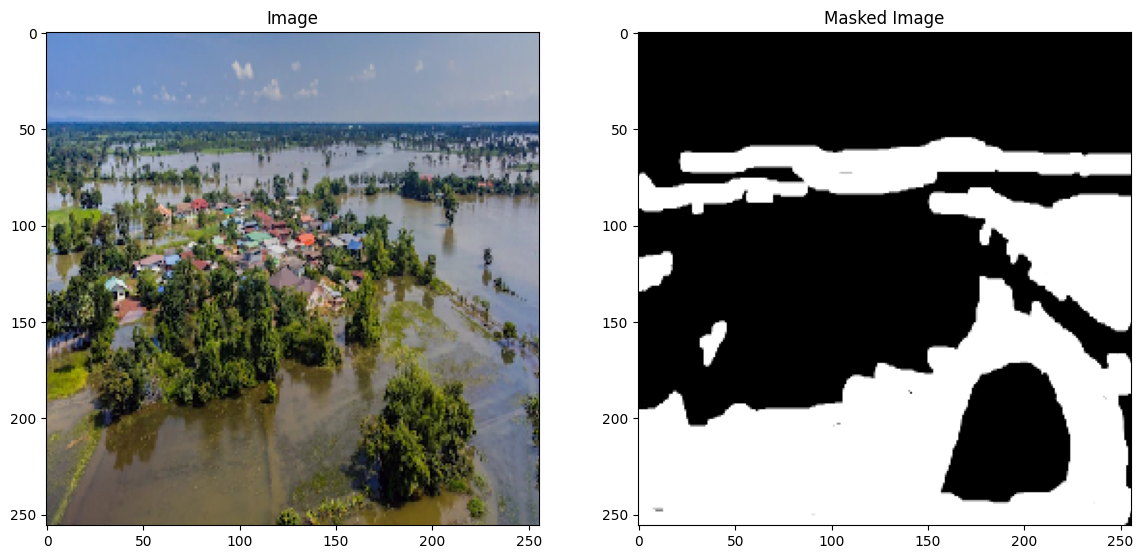

In [ ]:
random_image_id = random.randint(0, len(train_generator) - 1)
sample_image, sample_mask = train_generator[random_image_id]

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(sample_image[0]) 
plt.title("Image")

plt.subplot(122)
plt.imshow(sample_mask[0].squeeze(), cmap='gray') 
plt.title("Masked Image")
plt.show()

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

In [ ]:
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

def DeepLabV3Plus(shape):
    inputs = Input(shape)
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    x = Conv2D(1, (1, 1), name='output_layer')(x)
    x = Activation('sigmoid')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU, Precision, Recall

mIoU = MeanIoU(num_classes=2)
precision = Precision()
recall = Recall()

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1_score = 2 * (p * r) / (p + r + K.epsilon())
    return f1_score

def mean_iou(y_true, y_pred):
    return mIoU(y_true, y_pred)

def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred)

I0000 00:00:1746862196.888091      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746862196.888748      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
input_shape = (256, 256, 3)
model = DeepLabV3Plus(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=combined_loss,
              metrics=["accuracy",dice_coefficient, f1_score, mean_iou, precision, recall])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model_history=model.fit(train_generator, validation_data=val_generator, epochs=100)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746862248.614819      94 service.cc:148] XLA service 0x7b95a401fe30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746862248.615882      94 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746862248.615900      94 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746862252.989297      94 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1746862258.889024      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing war

  1/231 ━━━━━━━━━━━━━━━━━━━━ 4:52:15 76s/step - accuracy: 0.3117 - dice_coefficient: 0.3139 - f1_score: 0.3503 - loss: 0.9289 - mean_iou: 0.4020 - precision: 0.2227 - recall: 0.8194

I0000 00:00:1746862276.320496      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


231/231 ━━━━━━━━━━━━━━━━━━━━ 99s 99ms/step - accuracy: 0.7766 - dice_coefficient: 0.6597 - f1_score: 0.6671 - loss: 0.4141 - mean_iou: 0.3195 - precision: 0.7248 - recall: 0.7538 - val_accuracy: 0.5713 - val_dice_coefficient: 0.2185 - val_f1_score: 0.2412 - val_loss: 6.7624 - val_mean_iou: 0.3039 - val_precision: 0.4599 - val_recall: 0.1574
Epoch 2/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.8871 - dice_coefficient: 0.7906 - f1_score: 0.8683 - loss: 0.2476 - mean_iou: 0.3044 - precision: 0.9012 - recall: 0.8479 - val_accuracy: 0.5813 - val_dice_coefficient: 0.0863 - val_f1_score: 0.0917 - val_loss: 12.6393 - val_mean_iou: 0.2768 - val_precision: 0.4676 - val_recall: 0.0482
Epoch 3/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.9231 - dice_coefficient: 0.8505 - f1_score: 0.9224 - loss: 0.1727 - mean_iou: 0.2618 - precision: 0.9260 - recall: 0.9119 - val_accuracy: 0.5861 - val_dice_coefficient: 0.0288 - val_f1_score: 0.0236 - val_loss: 20.4101 - val_mean_io

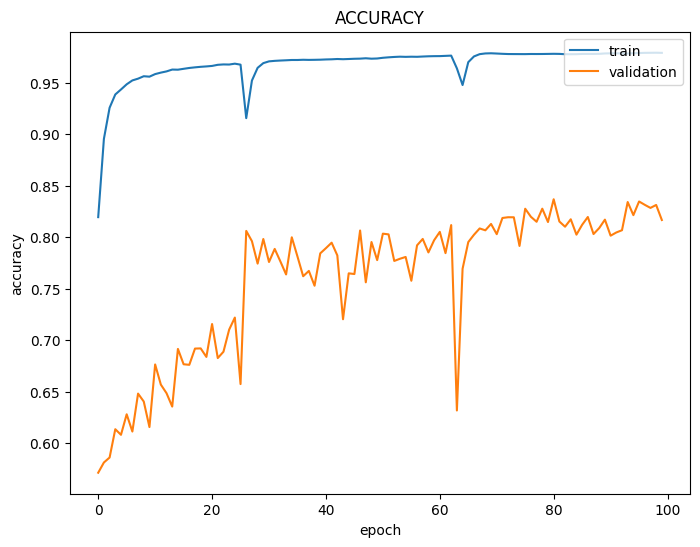

In [ ]:
fig,ax11=plt.subplots(figsize=(8,6))
ax11.plot(model_history.history['accuracy'])
ax11.plot(model_history.history['val_accuracy'])
ax11.title.set_text('ACCURACY')
ax11.set_ylabel('accuracy')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper right')

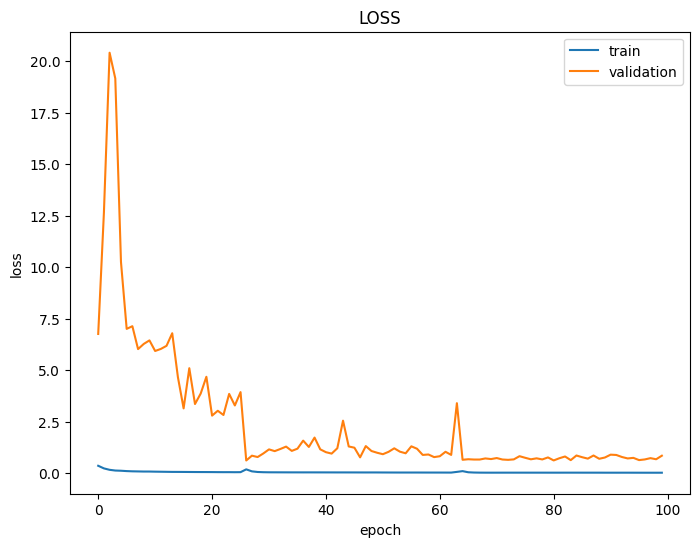

In [ ]:
fig,ax12 = plt.subplots(figsize=(8,6))
ax12.plot(model_history.history['loss'])
ax12.plot(model_history.history['val_loss'])
ax12.title.set_text('LOSS')
ax12.set_ylabel('loss')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper right')

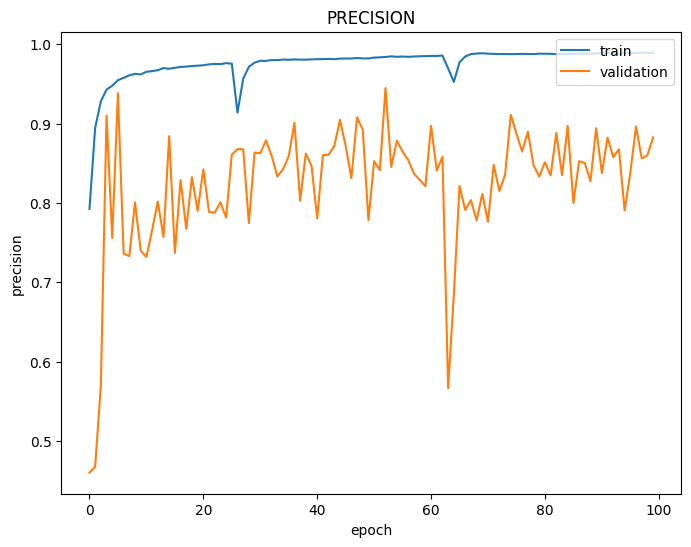

In [ ]:
fig,ax13=plt.subplots(figsize=(8,6))
ax13.plot(model_history.history['precision'])
ax13.plot(model_history.history['val_precision'])
ax13.title.set_text('PRECISION')
ax13.set_ylabel('precision')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper right')


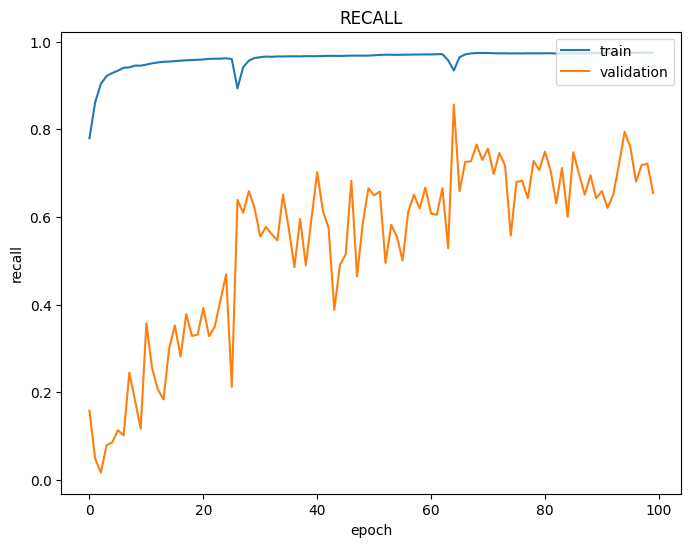

In [ ]:
fig,ax14=plt.subplots(figsize=(8,6))
ax14.plot(model_history.history['recall'])
ax14.plot(model_history.history['val_recall'])
ax14.title.set_text('RECALL')
ax14.set_ylabel('recall')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper right')

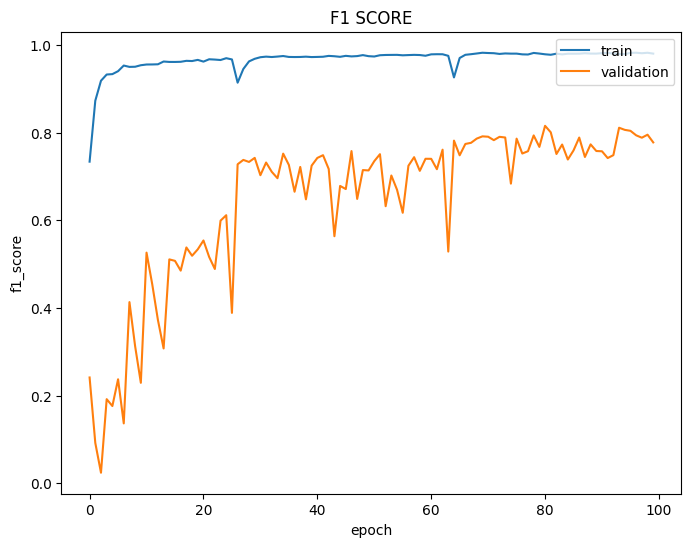

In [ ]:
fig,ax15=plt.subplots(figsize=(8,6))
ax15.plot(model_history.history['f1_score'])
ax15.plot(model_history.history['val_f1_score'])
ax15.title.set_text('F1 SCORE')
ax15.set_ylabel('f1_score')
ax15.set_xlabel('epoch')
ax15.legend(['train', 'validation'], loc='upper right')

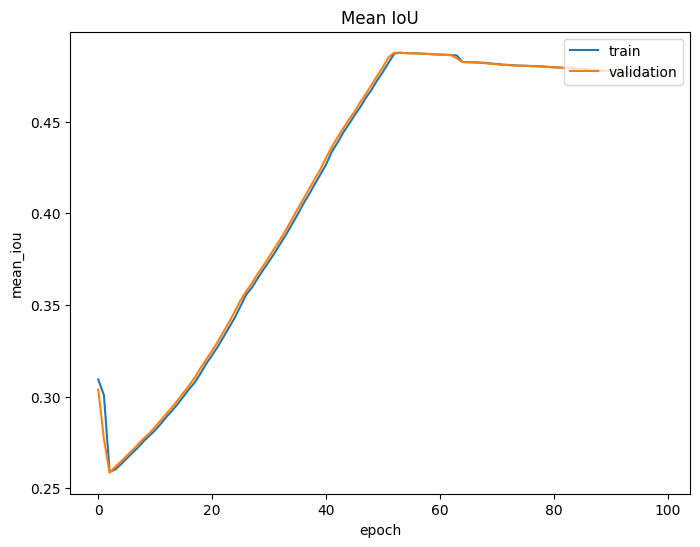

In [ ]:
fig,ax16=plt.subplots(figsize=(8,6))
ax16.plot(model_history.history['mean_iou'])
ax16.plot(model_history.history['val_mean_iou'])
ax16.title.set_text('Mean IoU')
ax16.set_ylabel('mean_iou')
ax16.set_xlabel('epoch')
ax16.legend(['train', 'validation'], loc='upper right')

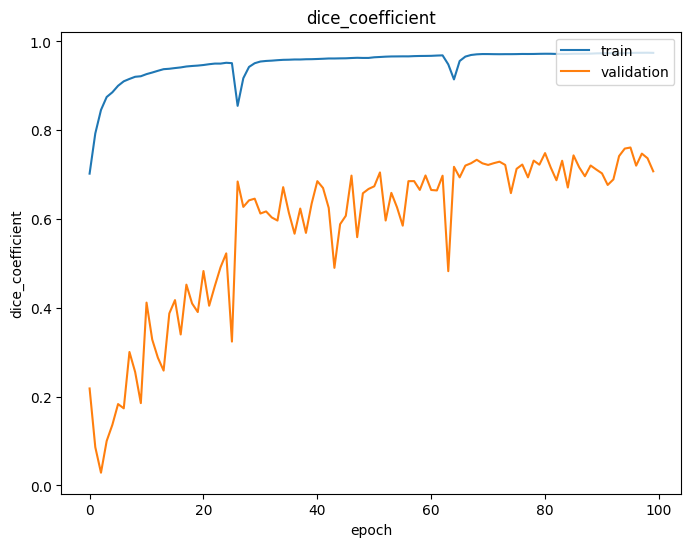

In [ ]:
fig,ax17=plt.subplots(figsize=(8,6))
ax17.plot(model_history.history['dice_coefficient'])
ax17.plot(model_history.history['val_dice_coefficient'])
ax17.title.set_text('dice_coefficient')
ax17.set_ylabel('dice_coefficient')
ax17.set_xlabel('epoch')
ax17.legend(['train', 'validation'], loc='upper right')

In [ ]:
pred_masks = model.predict(test_generator)
pred_masks = (pred_masks > 0.5).astype(np.uint8)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step


In [ ]:
loss,dice_coefficient, accuracy, f1_score, precision, recall,mean_iou = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"dice coefficient: {dice_coefficient:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test MeanIoU: {mean_iou:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8149 - dice_coefficient: 0.7052 - f1_score: 0.8004 - loss: 0.7743 - mean_iou: 0.4750 - precision: 0.8670 - recall: 0.6846
Test Loss: 0.7842
dice coefficient: 0.8398
Test Accuracy: 0.6872
Test F1 Score: 0.7670
Test Precision: 0.4750
Test Recall: 0.8615
Test MeanIoU: 0.6761


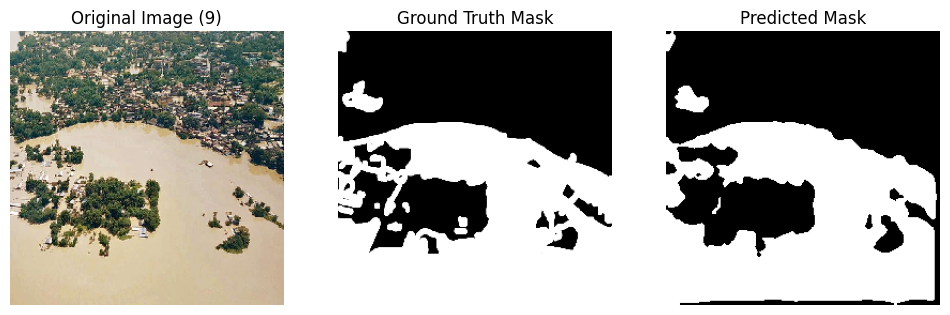

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def visualize_random_prediction(test_generator, pred_masks):
    idx = random.randint(0, len(test_generator) - 1)

    test_image, test_mask = test_generator[idx]


    test_image = test_image[0]
    test_mask = test_mask[0].squeeze()
    pred_mask = pred_masks[idx].squeeze()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title(f"Original Image ({idx})")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(test_mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()


visualize_random_prediction(test_generator, pred_masks)